In [135]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
%matplotlib inline

## Paths to data

In [137]:
# Definition of paths
data_dir = os.path.join(os.getcwd(), '../Dataset')

raw_data_dir = os.path.join(data_dir, 'raw')
ids_mapping = os.path.join(raw_data_dir, 'IDS_mapping.csv')
diabetes_data = os.path.join(raw_data_dir, 'diabetic_data.csv')

mapping_data_dir = os.path.join(data_dir, 'Mapping')
os.makedirs(mapping_data_dir, exist_ok=True)

preprocessed_out_dir = os.path.join(data_dir, 'Preprocessed')
os.makedirs(preprocessed_out_dir, exist_ok=True)

admission_type_mapping_data = os.path.join(mapping_data_dir, 'admission_type_mapping.csv')
discharge_disposition_data = os.path.join(mapping_data_dir, 'discharge_disposition_mapping.csv')
admission_source_mapping_data = os.path.join(mapping_data_dir, 'admission_source_mapping.csv')

preprocessed_saved_filepath = os.path.join(preprocessed_out_dir, 'preprocessed.pkl')

## Overview of the data.

In [138]:
# Lets load the main dataset
df = pd.read_csv(diabetes_data)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### Column Description ##
**Encounter ID:** Unique identifier of an encounter

**Patient number:** Unique identifier of a patient

**Race Values:** Caucasian, Asian, African American, Hispanic, and other

**Gender Values:** male, female, and unknown/invalid

**Age:** Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)

**Weight:** Weight in pounds

**Admission type:** Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available

**Discharge disposition:** Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available

**Admission source:** Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital

**Time in hospital:** Integer number of days between admission and discharge

**Payer code:** Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical

**Medical specialty:** Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon

**Number of lab procedures:** Number of lab tests performed during the encounter

**Number of procedures:** Numeric Number of procedures (other than lab tests) performed during the encounter

**Number of medications:** Number of distinct generic names administered during the encounter

**Number of outpatient visits:** Number of outpatient visits of the patient in the year preceding the encounter

**Number of emergency visits:** Number of emergency visits of the patient in the year preceding the encounter

**Number of inpatient visits:** Number of inpatient visits of the patient in the year preceding the encounter

**Diagnosis 1:** The primary diagnosis (coded as first three digits of ICD9); 848 distinct values

**Diagnosis 2:** Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values

**Diagnosis 3:** Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values

**Number of diagnoses:** Number of diagnoses entered to the system 0%

**Glucose serum test:** result Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured

**A1c test result:** Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.

**Change of medications:** Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”

**Diabetes medications:** Indicates if there was any diabetic medication prescribed. Values: “yes” and “no” 24 features for medications For the generic names: *metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride- pioglitazone, metformin-rosiglitazone, and metformin- pioglitazone*, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed

**Readmitted:** Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

## Cleaning up NaNs

### Handling missing values.

In the dataset, there are "?" sign that represented the NaN values. We shall replace that with np.nan.

In [140]:
# find out how many columns have '?' and the count of such values in different columns
na_summary = (df == '?').sum()
na_summary[na_summary != 0]

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

In [141]:
# Replace all ?s with NaN
df.replace('?', pd.NA, inplace=True)

### Columns with NaNs

In [142]:
# lets look at columns with NaNs
columns_with_nans = df.isna().sum()
columns_with_nans[columns_with_nans != 0]

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64

### Helper functions

In [143]:
def analyzeColumn(df, columnName):
    print(f'Column name: {columnName}')
    print(f'Data type: {df[columnName].dtype}')

    print()
    naSum = df[columnName].isna().sum()
    print(f'Count of NAs: {naSum}, %NAs = {naSum/len(df[columnName])*100}')

    print()
    uniqueValues = df[columnName].unique()
    print(f'Number of unique values: {len(uniqueValues)}')

    print()
    print('Unique values: ')
    print(f'{uniqueValues}')

    print()
    print('ValueCounts: ')
    print(df[columnName].value_counts())

    print()
    print('ValueCounts: Normalized')
    print(df[columnName].value_counts(normalize = True))

### Column: 'race'

In [144]:
analyzeColumn(df, 'race')

Column name: race
Data type: object

Count of NAs: 2273, %NAs = 2.2335554114340743

Number of unique values: 6

Unique values: 
['Caucasian' 'AfricanAmerican' <NA> 'Other' 'Asian' 'Hispanic']

ValueCounts: 
race
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

ValueCounts: Normalized
race
Caucasian          0.764868
AfricanAmerican    0.193079
Hispanic           0.020474
Other              0.015137
Asian              0.006443
Name: proportion, dtype: float64


In [145]:
# Lets convert NAs to "Unknown" and also convert the column to categorical
df['race'] = df['race'].fillna('Unknown')
df['race'] = df['race'].astype('category')

### Column: 'Weight'

In [146]:
analyzeColumn(df, 'weight')

Column name: weight
Data type: object

Count of NAs: 98569, %NAs = 96.85847925633315

Number of unique values: 10

Unique values: 
[<NA> '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']

ValueCounts: 
weight
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: count, dtype: int64

ValueCounts: Normalized
weight
[75-100)     0.417892
[50-75)      0.280576
[100-125)    0.195496
[125-150)    0.045355
[25-50)      0.030341
[0-25)       0.015014
[150-175)    0.010948
[175-200)    0.003441
>200         0.000938
Name: proportion, dtype: float64


~96% of rows have missing values, lets drop this column

In [147]:
df = df.drop(columns = 'weight')

### Column : 'payer_code'

In [148]:
analyzeColumn(df, 'payer_code')

Column name: payer_code
Data type: object

Count of NAs: 40256, %NAs = 39.5574160328597

Number of unique values: 18

Unique values: 
[<NA> 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC'
 'OT' 'OG' 'MP' 'FR']

ValueCounts: 
payer_code
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64

ValueCounts: Normalized
payer_code
MC    0.527378
HM    0.102000
SP    0.081401
BC    0.075679
MD    0.057422
CP    0.041180
UN    0.039798
CM    0.031491
OG    0.016794
PO    0.009624
DM    0.008925
CH    0.002374
WC    0.002195
OT    0.001544
MP    0.001284
SI    0.000894
FR    0.000016
Name: proportion, dtype: float64


The column has a high percentage of NaN values. Furthermore the column is unlikely to contribute to the outcome.
We will drop the column.

In [149]:
df = df.drop(columns='payer_code')

### Column: 'medical_specialty'

In [150]:
analyzeColumn(df, 'medical_specialty')

Column name: medical_specialty
Data type: object

Count of NAs: 49949, %NAs = 49.08220820313268

Number of unique values: 73

Unique values: 
['Pediatrics-Endocrinology' <NA> 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Neurology' 'Anesthesiology-Pediatric'
 'Radiology' 'Pediatrics-Hematology-Oncology' 'Psychology' 'Podiatry'
 'Gynecology' 'Oncology' 'Pediatrics-Neurology' 'Surgery-Plastic'
 'Surgery-Thoracic' 'Surgery-PlasticwithinHeadandNeck' 'Ophthalmology'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehab

The column has high percentage of missing values. However, the column may have a correlation with the outcome. We keep the column for now, and impute the missing values as "Unknown", we also change the column to categorical type.

In [151]:
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
df['medical_specialty'] = df['medical_specialty'].astype('category')

### Column: 'diag_1', 'diag_2', 'diag_3'

In [152]:
analyzeColumn(df, 'diag_1')

Column name: diag_1
Data type: object

Count of NAs: 21, %NAs = 0.02063557573256294

Number of unique values: 717

Unique values: 
['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' '737' '572' 'V57' '189' '786' '427' '996'
 '277' '584' '462' '473' '411' '174' '486' '998' '511' '432' '626' '295'
 '196' '250.6' '618' '182' '845' '423' '808' '250.4' '722' '403' '250.11'
 '784' '707' '440' '151' '715' '997' '198' '564' '812' '38' '590' '556'
 '578' '250.32' '433' 'V58' '569' '185' '536' '255' '250.13' '599' '558'
 '574' '491' '560' '244' '250.03' '577' '730' '188' '824' '250.8' '332'
 '562' '291' '296' '510' '401' '263' '438' '70' '250.02' '493' '642' '625'
 '571' '738' '593' '250.42' '807' '456' '446' '575' '250.41' '820' '515'
 '780' '250.22' '995' '235' '250.82' '721' '787' '162' '724' '282' '514'
 'V55' '281' '250.33' '530' '466' '435' '250.12' 'V53' '789' '566' '822'
 '191' '557' '733' '455' '711' '482' '202' '280' '553' '225' '154' '

In [153]:
analyzeColumn(df, 'diag_2')

Column name: diag_2
Data type: object

Count of NAs: 358, %NAs = 0.3517874339170253

Number of unique values: 749

Unique values: 
[<NA> '250.01' '250' '250.43' '157' '411' '492' '427' '198' '403' '288'
 '998' '507' '174' '425' '456' '401' '715' '496' '428' '585' '250.02'
 '410' '999' '996' '135' '244' '41' '571' '276' '997' '599' '424' '491'
 '553' '707' '286' '440' '493' '242' '70' 'V45' '250.03' '357' '511' '196'
 '396' '197' '414' '250.52' '577' '535' '413' '285' '53' '780' '518' '150'
 '566' '250.6' '867' '486' 'V15' '8' '788' '340' '574' '581' '228' '530'
 '250.82' '786' '294' '567' '785' '512' '305' '729' '250.51' '280' '648'
 '560' '618' '444' '38' 'V10' '578' '277' '781' '250.42' '278' '426' '584'
 '462' '402' '153' '272' '733' '34' '881' '203' '250.41' '250.13' '293'
 '245' '250.12' '558' '787' '342' '573' '626' '303' '250.53' '458' '710'
 '415' 'V42' '284' '569' '759' '682' '112' '292' '435' '290' '250.93'
 '642' '536' '398' '319' '711' 'E878' '446' '255' 'V44' '250.7' '784'

In [154]:
analyzeColumn(df, 'diag_3')

Column name: diag_3
Data type: object

Count of NAs: 1423, %NAs = 1.398305917497003

Number of unique values: 790

Unique values: 
[<NA> '255' 'V27' '403' '250' 'V45' '38' '486' '996' '197' '250.6' '427'
 '627' '414' '416' '714' '428' '582' 'V43' '250.01' '263' '250.42' '276'
 '482' '401' '250.41' '585' '781' '278' '998' '568' '682' '618' '250.02'
 '305' '707' '496' '599' '715' '424' '518' '553' '794' '411' 'V42' '531'
 '511' '490' '562' '250.8' '250.7' '250.52' '784' '491' '581' '420' '8'
 '724' '730' '789' '131' '250.82' '999' '41' '493' '250.03' '753' '786'
 '529' 'E888' '425' '595' '303' '560' '711' '492' '332' '296' '438' '362'
 '250.4' '654' '244' 'V70' '737' '625' '681' '250.51' '404' 'V10' '810'
 '280' '440' '785' '588' '569' '272' '997' '250.43' '918' '584' '54' '788'
 '426' '722' '250.92' '196' '461' '535' '787' '891' '284' '458' '648'
 '780' '182' '285' '593' '413' '664' '564' '201' '356' 'V15' '292' '782'
 '473' '455' 'E932' '357' '348' '294' '250.23' '459' 'E878' '437' '73

Diagnosis columns are very fine grained, we instead bin the values to speicific groups for simpler analysis.- We also change the columns to type category.

In [155]:
import re

# Function transform_value(value): Standardizes diagnostic codes by replacing values beginning with 'V' or 'E' with '0' and filling in missing values as '-1'.
def transform_value(value):
    value = re.sub("V[0-9]*", "0", value) # V 
    value = re.sub("E[0-9]*", "0", value) # E 
    value = re.sub('NaN', "-1", value) # Nan 
    return value

def transform_category(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'          
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'NAN'
    else :
        category = 'Other'


In [156]:
# Function preprocess_diag_column(df): Applies transform_value and transform_category transformations to each diagnostic column (diag_1, diag_2, diag_3), replacing raw codes with categorical labels.
def preprocess_diag_columns(df, diag_list):
    for col in diag_list:
        df[col]= df[col].fillna('NaN')
    for col in diag_list:
        df[col] = df[col].apply(transform_value)
        df[col] = df[col].astype(float)
    for col in diag_list:
        df[col] = df[col].apply(transform_category).astype('category')
    return df

In [157]:
diag_list = ['diag_1','diag_2','diag_3']
df = preprocess_diag_columns(df, diag_list)

### Column: 'max_glu_serum'

In [158]:
analyzeColumn(df, 'max_glu_serum')

Column name: max_glu_serum
Data type: object

Count of NAs: 96420, %NAs = 94.74677200636755

Number of unique values: 4

Unique values: 
[nan '>300' 'Norm' '>200']

ValueCounts: 
max_glu_serum
Norm    2597
>200    1485
>300    1264
Name: count, dtype: int64

ValueCounts: Normalized
max_glu_serum
Norm    0.485784
>200    0.277778
>300    0.236438
Name: proportion, dtype: float64


We impute the missing values with 'Unknown'

In [159]:
df['max_glu_serum'] = df['max_glu_serum'].fillna('Unknown')

### Column: 'A1Cresult'

In [160]:
analyzeColumn(df, 'A1Cresult')

Column name: A1Cresult
Data type: object

Count of NAs: 84748, %NAs = 83.27732248491637

Number of unique values: 4

Unique values: 
[nan '>7' '>8' 'Norm']

ValueCounts: 
A1Cresult
>8      8216
Norm    4990
>7      3812
Name: count, dtype: int64

ValueCounts: Normalized
A1Cresult
>8      0.482783
Norm    0.293219
>7      0.223998
Name: proportion, dtype: float64


We fill NaNs with 'Unknown'

In [161]:
df['A1Cresult'] = df['A1Cresult'].fillna('Unknown')

## Handling Medicine columns

In [162]:
medicineColumns = ['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

Many of the medicine columns are sparse, lets first take a look at the sparsity of the values.

In [163]:
def analyzeSparsity(df):
    sparse_cols = (df == 'No').sum() / df.shape[0]
    sparse_cols.sort_values(ascending=False, inplace=True)

    sparse_cols_filtered = sparse_cols[sparse_cols >= 0.99].index
    nonsparse_cols_filtered = sparse_cols[sparse_cols <= 0.99].index

    max_len = max(len(col) for col in sparse_cols.index)

    print("Sparse columns (>=99% with value 'No'): \n")
    for col in sparse_cols_filtered:
        print(f"{col:<{max_len}} - sparcity: {sparse_cols[col]:.4f}")
        
    print("\nNon-sparse columns (<99% with value 'No'): \n")
    for col in nonsparse_cols_filtered:
        print(f"{col:<{max_len}} - sparcity: {sparse_cols[col]:.4f}")

    return sparse_cols_filtered, nonsparse_cols_filtered

In [164]:
sparse_medicine_columns, nonsparse_medicine_columns = analyzeSparsity(df[medicineColumns])

Sparse columns (>=99% with value 'No'): 

citoglipton              - sparcity: 1.0000
examide                  - sparcity: 1.0000
acetohexamide            - sparcity: 1.0000
metformin-pioglitazone   - sparcity: 1.0000
glimepiride-pioglitazone - sparcity: 1.0000
metformin-rosiglitazone  - sparcity: 1.0000
troglitazone             - sparcity: 1.0000
glipizide-metformin      - sparcity: 0.9999
tolbutamide              - sparcity: 0.9998
miglitol                 - sparcity: 0.9996
tolazamide               - sparcity: 0.9996
chlorpropamide           - sparcity: 0.9992
acarbose                 - sparcity: 0.9970
nateglinide              - sparcity: 0.9931
glyburide-metformin      - sparcity: 0.9931

Non-sparse columns (<99% with value 'No'): 

repaglinide              - sparcity: 0.9849
glimepiride              - sparcity: 0.9490
rosiglitazone            - sparcity: 0.9375
pioglitazone             - sparcity: 0.9280
glyburide                - sparcity: 0.8953
glipizide                - sparc

Following medicines have sparse values > 99% values are with No medicine administered. We will drop these columns

In [165]:
df = df.drop(columns = sparse_medicine_columns)

## Object Columns

In [166]:
df.select_dtypes(include=['object']).columns

Index(['gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

### Column: 'gender

In [167]:
analyzeColumn(df, 'gender')

Column name: gender
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 3

Unique values: 
['Female' 'Male' 'Unknown/Invalid']

ValueCounts: 
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

ValueCounts: Normalized
gender
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: proportion, dtype: float64


There are just 3 rows with 'gender' as 'Unknown/Invalid'. Lets drop these rows

In [168]:
df = df.drop(df[df['gender'] == 'Unknown/Invalid'].index)

### Column: 'age'

In [169]:
analyzeColumn(df, 'age')

Column name: age
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 10

Unique values: 
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

ValueCounts: 
age
[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

ValueCounts: Normalized
age
[70-80)     0.256144
[60-70)     0.220925
[50-60)     0.169570
[80-90)     0.168991
[40-50)     0.095172
[30-40)     0.037096
[90-100)    0.027446
[20-30)     0.016283
[10-20)     0.006790
[0-10)      0.001582
Name: proportion, dtype: float64


There are very few values < 30, lets bin them to a single bin.

In [170]:
bin_edges = [0, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df['age-binned'] = pd.cut(df['age'].str.extract('(\d+)')[0].astype(int), bins=bin_edges, labels=bin_labels, right=False)

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2615/1969488850.py:3: SyntaxWarning: invalid escape sequence '\d'
  df['age-binned'] = pd.cut(df['age'].str.extract('(\d+)')[0].astype(int), bins=bin_edges, labels=bin_labels, right=False)


### Column: 'max_glu_serum'

In [171]:
analyzeColumn(df, 'max_glu_serum')

Column name: max_glu_serum
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 4

Unique values: 
['Unknown' '>300' 'Norm' '>200']

ValueCounts: 
max_glu_serum
Unknown    96417
Norm        2597
>200        1485
>300        1264
Name: count, dtype: int64

ValueCounts: Normalized
max_glu_serum
Unknown    0.947466
Norm       0.025520
>200       0.014593
>300       0.012421
Name: proportion, dtype: float64


Indicates the range of the result or if the test was not taken.  
Values: “>200,” “>300,”, “normal,” and “Unknown” if not measured.  

We split the column to two columns:  

**max_glu_serum** = Ordinal encoding  
0 : Unknown/Not measured.  
1 : Norm.  
2 : >200.  
3 : >300.  

**max_glu_serum_measured** = Categorical  
Yes : If the values were measured  
No  : Otherwise 

In [172]:
# Create the 'measured' column (Yes/No)
df['max_glu_serum_measured'] = df['max_glu_serum'].apply(lambda x: 'No' if x == 'Unknown' else 'Yes')
df['max_glu_serum_measured'] = df['max_glu_serum_measured'].astype('category')
ordinal_mapping = {'Unknown' : 0, 'Norm': 1, '>200': 2, '>300': 3 }
df['max_glu_serum'] = df['max_glu_serum'].map(ordinal_mapping)

### Column: 'A1Cresult'

In [173]:
analyzeColumn(df, 'A1Cresult')

Column name: A1Cresult
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 4

Unique values: 
['Unknown' '>7' '>8' 'Norm']

ValueCounts: 
A1Cresult
Unknown    84745
>8          8216
Norm        4990
>7          3812
Name: count, dtype: int64

ValueCounts: Normalized
A1Cresult
Unknown    0.832768
>8         0.080737
Norm       0.049036
>7         0.037460
Name: proportion, dtype: float64


Indicates the range of the result or if the test was not taken.  
Values: “>8,” “>7,”, “Norm,” and “Unknown” if not measured.  

We split the column to two columns:  

**A1Cresult** = Ordinal encoding  
0 : Unknown/Not measured.  
1 : Norm.  
2 : >200.  
3 : >300.  

**A1Cresult_measured** = Categorical  
Yes : If the values were measured  
No  : Otherwise 

In [174]:
df['A1Cresult_measured'] = df['A1Cresult'].apply(lambda x: 'No' if x == 'Unknown' else 'Yes')
df['A1Cresult_measured'] = df['A1Cresult_measured'].astype('category')
ordinal_mapping = {'Unknown' : 0, 'Norm': 1, '>7': 2, '>8': 3 }
df['A1Cresult'] = df['A1Cresult'].map(ordinal_mapping)

### Column: Medicine columns

In [175]:
for medicine_column in nonsparse_medicine_columns.to_list():
    analyzeColumn(df, medicine_column)
    print('\n ------------------------------------------- \n')

Column name: repaglinide
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 4

Unique values: 
['No' 'Up' 'Steady' 'Down']

ValueCounts: 
repaglinide
No        100224
Steady      1384
Up           110
Down          45
Name: count, dtype: int64

ValueCounts: Normalized
repaglinide
No        0.984877
Steady    0.013600
Up        0.001081
Down      0.000442
Name: proportion, dtype: float64

 ------------------------------------------- 

Column name: glimepiride
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 4

Unique values: 
['No' 'Steady' 'Down' 'Up']

ValueCounts: 
glimepiride
No        96572
Steady     4670
Up          327
Down        194
Name: count, dtype: int64

ValueCounts: Normalized


glimepiride
No        0.948989
Steady    0.045891
Up        0.003213
Down      0.001906
Name: proportion, dtype: float64

 ------------------------------------------- 

Column name: rosiglitazone
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 4

Unique values: 
['No' 'Steady' 'Up' 'Down']

ValueCounts: 
rosiglitazone
No        95399
Steady     6099
Up          178
Down         87
Name: count, dtype: int64

ValueCounts: Normalized
rosiglitazone
No        0.937463
Steady    0.059933
Up        0.001749
Down      0.000855
Name: proportion, dtype: float64

 ------------------------------------------- 

Column name: pioglitazone
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 4

Unique values: 
['No' 'Steady' 'Up' 'Down']

ValueCounts: 
pioglitazone
No        94436
Steady     6975
Up          234
Down        118
Name: count, dtype: int64

ValueCounts: Normalized
pioglitazone
No        0.927999
Steady    0.068542
Up        0.002299
Down      

These columns indicate dosage of medicines administered to the patient. Question: Are these the values that are administered during the visit? If so it will not impact the outcomes. We come back to this question later on. For now we adopt following approach:  

We split the column to two columns:  

**medicinename** = Ordinal encoding  
-1 : Down, dosage was reduced.  
 0 : No, medicine was not administered.  
 1 : Steady, dosage was not changed.  
 2 : Up, dosage was increased.  

**medicinename_measured** = Categorical  
Yes : If the values were measured  
No  : Otherwise 

In [176]:
for col in nonsparse_medicine_columns.to_list():
  df[f'{col}_measured'] = df[col].apply(lambda x: 'No' if x == 'No' else 'Yes')
  df[f'{col}_measured'] = df[f'{col}_measured'].astype('category')
  
  ordinal_mapping = {'Down' : -1, 'No': 0, 'Steady': 1, 'Up': 2 }
  df[col] = df[col].map(ordinal_mapping)

### Column: 'change'

In [177]:
analyzeColumn(df, 'change')

Column name: change
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 2

Unique values: 
['No' 'Ch']

ValueCounts: 
change
No    54754
Ch    47009
Name: count, dtype: int64

ValueCounts: Normalized
change
No    0.538054
Ch    0.461946
Name: proportion, dtype: float64


The column has just two values. We convert it to categorical type.

In [178]:
df['change'] = df['change'].astype('category')

### Column: 'diabetesMed'

In [179]:
analyzeColumn(df, 'diabetesMed')

Column name: diabetesMed
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 2

Unique values: 
['No' 'Yes']

ValueCounts: 
diabetesMed
Yes    78361
No     23402
Name: count, dtype: int64

ValueCounts: Normalized
diabetesMed
Yes    0.770034
No     0.229966
Name: proportion, dtype: float64


It is a simple categorical column.

In [180]:
df['diabetesMed'] = df['diabetesMed'].astype('category')

### Column: 'readmitted', the target feature


If the patient was readmitted in less than 30 days, then the value is "<30"
If the patient was readmitted in more than 30 days, then the value is ">30"
If the patient was never readmitted, then the value is NO
Since we want to determine whether the patient was readmitted irrespective of number of days, hence

If the patient was never readmitted, then the value is 0.
If the patient was readmitted, then value is 1.

In [181]:
analyzeColumn(df, 'readmitted')

Column name: readmitted
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 3

Unique values: 
['NO' '>30' '<30']

ValueCounts: 
readmitted
NO     54861
>30    35545
<30    11357
Name: count, dtype: int64

ValueCounts: Normalized
readmitted
NO     0.539106
>30    0.349292
<30    0.111602
Name: proportion, dtype: float64


For first analysis lets consider readmission <30 days and >30 days as just readmission : YES. Also change the column to type categorical.

In [182]:
df['readmitted'] = df['readmitted'].str.replace('>30', 'YES')
df['readmitted'] = df['readmitted'].str.replace('<30', 'YES')
df['readmitted'] = df['readmitted'].astype('category')

## The numerical columns

In [183]:
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin'],
      dtype='object')

The columns 'encounter_id' and 'patient_nbr' are unique ids. We keep them as is.

### Some helper functions

In [184]:
def analyzeNumericalColumn(df, columnName):
    print(f'Column name: {columnName}')
    print(f'Data type: {df[columnName].dtype}')

    print()
    naSum = df[columnName].isna().sum()
    print(f'Count of NAs: {naSum}, %NAs = {naSum/len(df[columnName])*100}')

    print()
    uniqueValues = df[columnName].unique()
    print(f'Number of unique values: {len(uniqueValues)}')

    print()
    print('Unique values: ')
    print(f'{uniqueValues}')

    print()
    print('Value counts: ')
    print(df[columnName].value_counts())

    print()
    print('Statistics')
    print(df[columnName].describe())


### Column: 'admission_type_id'

In [185]:
admtypid_df = pd.read_csv(admission_type_mapping_data)
admtypid_df.rename(columns={'description' : 'AdmissionType'}, inplace=True)
admtypid_df

,admission_type_id,AdmissionType
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [186]:
jdf = pd.merge(df, admtypid_df, on = 'admission_type_id', how ='inner')

In [187]:
analyzeNumericalColumn(jdf, 'AdmissionType')

Column name: AdmissionType
Data type: object

Count of NAs: 5291, %NAs = 5.199335711407879

Number of unique values: 8

Unique values: 
[nan 'Emergency' 'Urgent' 'Elective' 'Newborn' 'Not Available'
 'Not Mapped' 'Trauma Center']

Value counts: 
AdmissionType
Emergency        53988
Elective         18868
Urgent           18480
Not Available     4785
Not Mapped         320
Trauma Center       21
Newborn             10
Name: count, dtype: int64

Statistics
count         96472
unique            7
top       Emergency
freq          53988
Name: AdmissionType, dtype: object


admission_type_id is in fact categorical. Lets change the type to categorical.

In [188]:
df['admission_type_id'] = df['admission_type_id'].astype('category')

### Column: 'discharge_disposition_id'

In [189]:
disdisp_df = pd.read_csv(discharge_disposition_data)
disdisp_df.rename(columns = {'description' : "DischargeDisposition"}, inplace=True)
# impute NaNs
disdisp_df.fillna('Unknown', inplace = True)

In [190]:
jdf = pd.merge(df, disdisp_df, on = 'discharge_disposition_id', how = 'inner')

In [191]:
analyzeNumericalColumn(jdf, 'DischargeDisposition')

Column name: DischargeDisposition
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 26

Unique values: 
['Not Mapped' 'Discharged to home' 'Discharged/transferred to SNF'
 'Discharged/transferred to home with home health service'
 'Discharged/transferred to another short term hospital'
 'Discharged/transferred to another type of inpatient care institution'
 'Expired' 'Left AMA'
 'Neonate discharged to another hospital for neonatal aftercare'
 'Discharged/transferred to ICF' 'Hospice / medical facility' 'Unknown'
 'Discharged/transferred to home under care of Home IV provider'
 'Hospice / home'
 'Still patient or expected to return for outpatient services'
 'Discharged/transferred/referred another institution for outpatient services'
 'Discharged/transferred/referred to this institution for outpatient services'
 'Discharged/transferred to another rehab fac including rehab units of a hospital .'
 'Discharged/transferred to a long term care hospital.'
 'Admitted as 

Drop rows which have discharge disposition id mapping to either hospice or expired

In [192]:
valuesToDiscard = ['expired', 'hospice']
expired_disp_ids = disdisp_df[disdisp_df['DischargeDisposition'].str.contains('expired|hospice', case=False, regex=True)]['discharge_disposition_id']
df = df[~df['discharge_disposition_id'].isin(expired_disp_ids)]

Even the column discharge_disposition_id is in fact categorical. Lets change the column to categorical type.

In [193]:
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('category')

We ignore the rows where the patient either expired or moved to hospice.

### Column: 'admission_source_id'

In [194]:
analyzeNumericalColumn(df, 'admission_source_id')

Column name: admission_source_id
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 17

Unique values: 
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]

Value counts: 
admission_source_id
7     55848
1     29167
17     6570
4      3118
6      2239
2      1081
5       806
3       185
20      159
9       125
8        15
22       12
10        8
14        2
11        2
25        2
13        1
Name: count, dtype: int64

Statistics
count    99340.000000
mean         5.731105
std          4.065059
min          1.000000
25%          1.000000
50%          7.000000
75%          7.000000
max         25.000000
Name: admission_source_id, dtype: float64


Again the column admission_source_id is categorical. Lets change the type.

In [195]:
df['admission_source_id'] = df['admission_source_id'].astype('category')

### Column: 'time_in_hospital'

In [196]:
analyzeNumericalColumn(df, 'time_in_hospital')

Column name: time_in_hospital
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 14

Unique values: 
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]

Value counts: 
time_in_hospital
3     17432
2     16891
1     13822
4     13684
5      9749
6      7355
7      5696
8      4270
9      2879
10     2262
11     1770
12     1383
13     1152
14      995
Name: count, dtype: int64

Statistics
count    99340.000000
mean         4.379364
std          2.968393
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         14.000000
Name: time_in_hospital, dtype: float64


We keep the column as numerical.

### Column: 'num_lab_procedures'

In [197]:
analyzeNumericalColumn(df, 'num_lab_procedures')

Column name: num_lab_procedures
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 118

Unique values: 
[ 41  59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29
  35  42  66  36  19  64  25  53  52  87  27  37  28  48  10   2  65  67
  40  54  58  57  43  32  83  34  39  69  38  72  22  96  46  78  56  61
  88  50   1  18  82   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  15  12  30  23  17  21  79  26   5  95  97  84  14  74 105  86
  98  20   6  94   8 102   7  89  91  92   4 101  99 100 114 113 111 129
 107 108 106 104 109 120 132 121 126 118]

Value counts: 
num_lab_procedures
1      3153
43     2752
44     2447
45     2331
38     2179
       ... 
120       1
132       1
121       1
126       1
118       1
Name: count, Length: 118, dtype: int64

Statistics
count    99340.000000
mean        42.907198
std         19.609887
min          1.000000
25%         31.000000
50%         44.000000
75%         57.000000
max        132.000000
N

We keep this column as is.

### Column: 'num_procedures'

In [198]:
analyzeNumericalColumn(df, 'num_procedures')

Column name: num_procedures
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 7

Unique values: 
[0 5 1 6 2 3 4]

Value counts: 
num_procedures
0    45679
1    20249
2    12372
3     9203
6     4801
4     4049
5     2987
Name: count, dtype: int64

Statistics
count    99340.000000
mean         1.334196
std          1.702770
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: num_procedures, dtype: float64


We keep this column as is.

### Column: 'num_medications'

In [199]:
analyzeNumericalColumn(df, 'num_medications')

Column name: num_medications
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 75

Unique values: 
[ 1 18 13 16  8 21 12 28 17 11 15 31  2 23 19  7 20 14 10 22  9 25  4 32
  6 26 24 33  5 27 39  3 30 29 61 40 46 41 36 34 35 50 43 42 37 51 38 45
 54 52 49 62 55 47 44 53 48 57 59 56 60 63 58 70 67 64 69 65 68 66 81 79
 75 72 74]

Value counts: 
num_medications
13    5976
12    5888
11    5696
15    5694
14    5592
      ... 
70       2
75       2
81       1
79       1
74       1
Name: count, Length: 75, dtype: int64

Statistics
count    99340.000000
mean        15.979052
std          8.094931
min          1.000000
25%         10.000000
50%         15.000000
75%         20.000000
max         81.000000
Name: num_medications, dtype: float64


We keep this column as is.

### Column: 'number_outpatient'

In [200]:
analyzeNumericalColumn(df, 'number_outpatient')

Column name: number_outpatient
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 39

Unique values: 
[ 0  2  1  5  7  9  3  8  4 12 11  6 20 15 10 13 14 16 21 35 17 29 36 18
 19 27 22 24 42 39 34 26 33 25 23 28 37 38 40]

Value counts: 
number_outpatient
0     82991
1      8349
2      3509
3      1997
4      1077
5       514
6       294
7       154
8        96
9        82
10       57
11       41
13       30
12       29
14       28
15       20
16       13
17        8
20        6
21        6
18        5
22        5
19        3
24        3
27        3
35        2
29        2
36        2
23        2
33        2
26        2
34        1
39        1
42        1
25        1
28        1
37        1
38        1
40        1
Name: count, dtype: int64

Statistics
count    99340.000000
mean         0.369257
std          1.265160
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.000000
Name: number_outpatient, dtype: float64


We keep this column as is.

### Column: 'number_emergency'

In [201]:
analyzeNumericalColumn(df, 'number_emergency')

Column name: number_emergency
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 33

Unique values: 
[ 0  1  2  4  3  9  5  7  6  8 22 25 10 13 42 16 11 28 15 14 18 12 21 20
 19 46 76 37 64 63 54 24 29]

Value counts: 
number_emergency
0     88246
1      7474
2      1984
3       706
4       369
5       190
6        93
7        72
8        50
10       34
9        33
11       23
13       12
12       10
22        6
18        5
16        5
20        4
19        4
15        3
14        3
21        2
25        2
42        1
28        1
46        1
76        1
37        1
64        1
63        1
54        1
24        1
29        1
Name: count, dtype: int64

Statistics
count    99340.000000
mean         0.198450
std          0.937747
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         76.000000
Name: number_emergency, dtype: float64


We keep this column as is.

### Column: 'number_inpatient'

In [202]:
analyzeNumericalColumn(df, 'number_inpatient')

Column name: number_inpatient
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 21

Unique values: 
[ 0  1  2  3  6  5  4  7  9  8 15 10 11 14 12 13 17 16 21 18 19]

Value counts: 
number_inpatient
0     66242
1     18984
2      7300
3      3271
4      1574
5       791
6       474
7       262
8       145
9       109
10       59
11       49
12       32
13       18
14       10
15        9
16        6
19        2
17        1
21        1
18        1
Name: count, dtype: int64

Statistics
count    99340.000000
mean         0.630954
std          1.260443
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         21.000000
Name: number_inpatient, dtype: float64


We keep this column as is.

### Column: 'number_diagnoses'

In [203]:
analyzeNumericalColumn(df, 'number_diagnoses')

Column name: number_diagnoses
Data type: int64

Count of NAs: 0, %NAs = 0.0

Number of unique values: 16

Unique values: 
[ 1  9  6  7  5  8  3  4  2 16 12 13 15 10 11 14]

Value counts: 
number_diagnoses
9     47809
5     11300
8     10359
7     10215
6      9986
4      5498
3      2824
2      1021
1       219
16       42
13       16
10       16
11       11
15       10
12        8
14        6
Name: count, dtype: int64

Statistics
count    99340.000000
mean         7.401752
std          1.940990
min          1.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         16.000000
Name: number_diagnoses, dtype: float64


We keep this column as is.

With this, we are done with cleaning up all columns in the dataframe.

## Duplicate rows handling

In [204]:
duplicatedPatients = df['patient_nbr'].duplicated().sum()
print(f'Number of duplicated patients: {duplicatedPatients}, percentage = {duplicatedPatients/len(df)*100}')

Number of duplicated patients: 29353, percentage = 29.54801691161667


Lets look at how many encounters, a patient had across dataset.

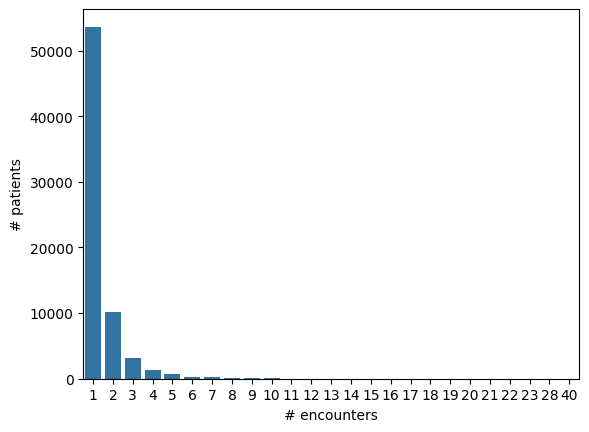

In [205]:
df_patvisits = df.groupby('patient_nbr')['encounter_id'].count().reset_index(name = '#encounters') \
.groupby('#encounters')['patient_nbr'].count().reset_index(name = '#patients') \
.sort_values(by = '#patients', ascending = False).set_index('#encounters')
sns.barplot(x = df_patvisits.index, y = df_patvisits['#patients'])
plt.xlabel('# encounters')
plt.ylabel('# patients')
plt.show()

For now, we keep just the first encounter for a given patient.

In [206]:
df = df.drop_duplicates(subset = ['patient_nbr'], keep = 'first')

## Save the file locally.

In [207]:
df.to_pickle(preprocessed_saved_filepath)